In [7]:
# PreSetup
!pip install numpy
!pip install networkx
!pip install matplotlib
!pip install sklearn
!pip install seaborn
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install tweepy

In [8]:
# Representing data
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

# Word Tokenization
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# NLTK
import nltk

# Data Representation
import pandas as pd
import string
import csv
import json

# Twitter API
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener

# Utils
from datetime import datetime
from dateutil import parser

import warnings
import re
import os
import ssl

import time

In [9]:
# NLTK Data

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/nbuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/nbuser/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [10]:
class MemoryListner(StreamListener):
    """ A listener handles tweets that are received from the stream.
    This is a basic listener that just adds received tweets to memory.
    """
    
    def __init__(self, maxNumberOfTweets):
        self.maxTweets = maxNumberOfTweets
        self.tweetCount = 0
        
        self.tweets = []
        
    def on_data(self, data):
        # We want to get just a small number of tweets
        if (self.tweetCount < self.maxTweets):
            self.tweetCount += 1
            
            self.tweets.append(data)
            
            return True
        else:
            return False

    def on_error(self, status):
        print(status)
        
    def getTweets(self):
        return self.tweets

In [11]:
# Go to http://apps.twitter.com and create an app.
# The consumer key and secret will be generated for you after
consumer_key=""
consumer_secret=""

# After the step above, you will be redirected to your app's page.
# Create an access token under the the "Your access token" section
access_token=""
access_token_secret=""

# Configure the maximum number of tweets
maxNumberOfTweets = 1000

# We will use this to align the tweets
dateFormat = '%Y-%m-%d %H:%M:%S'

In [12]:
# Create a listner for the Stream
listner = MemoryListner(maxNumberOfTweets)

# Generate an authenticator
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# We will listen to the Stream only for english and 
# we should add some common words to look for
stream = Stream(auth, listner)
stream.filter(languages=["en"], track=["a", "and", "or", "the", "i", "you", "u"])

In [13]:
# Those are the english words that will be omitted
default_stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "rt", "http"]

In [14]:
# We will use lemmatization. If you want to know more, please visit:
# https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/
wordnet_lemmatizer = WordNetLemmatizer()

In [15]:
# Standard ED Text Cleaning
def cleanText(text, stop_words=default_stopwords, extra_words = []):
        def tokenize_text(text):
            return [w for s in sent_tokenize(text) for w in word_tokenize(s)]

        def remove_special_characters(text):
            tokens = tokenize_text(text)
            return ' '.join(re.sub('[^a-z]+', '', x) for x in tokens)

        def lemma_text(text, lemmatizer=wordnet_lemmatizer):
            tokens = tokenize_text(text)
            return ' '.join([lemmatizer.lemmatize(t) for t in tokens])

        def remove_stopwords(text, stop_words= (stop_words + extra_words)):
            tokens = [w for w in tokenize_text(text) if w not in stop_words]
            return ' '.join(tokens)

        text = str(text).strip(' ') # strip whitespaces
        text = text.lower() # lowercase
        text = remove_special_characters(text) # remove punctuation and symbols
        text = lemma_text(text) # stemming
        text = remove_stopwords(text) # remove stopwords
        text = text.strip(' ') # strip whitespaces again?

        return text

In [16]:
# Get All tweets and prepare some list for data
data = []
allTweets = listner.getTweets()

In [17]:
# Parse the tweets and take only the 2 columns of interest
for tweet in allTweets:
    y = json.loads(tweet)
    try:
        text = cleanText(y['text'])

        date = parser.parse(y['created_at'])
        datetime = date.strftime(dateFormat)

        data.append([text, datetime])
        
    except:
        None

In [18]:
# Convert to a pandas DataFrame
print('Number of parsed tweets = ' + str(len(data)))

df = pd.DataFrame(data, columns=['text', 'date'])
df.head()

Number of parsed tweets = 981


,text,date
0,chlriedes nt like talk m mad bcs word hurt som...,2019-11-20 15:24:41
1,boss brought desk think might trying say somet...,2019-11-20 15:24:40
2,pradakookie nomination doesn change fact much ...,2019-11-20 15:24:41
3,loveetodream btstwt bet even fan would agree a...,2019-11-20 15:24:41
4,sjpeace turkey ha following ups truck througho...,2019-11-20 15:24:41


In [19]:
def getTopics(model, count_vectorizer, n_top_words):
        words = count_vectorizer.get_feature_names()
        data_labels = []

        for _, topic in enumerate(model.components_):
            data_labels.append(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

        topics = pd.DataFrame(data=data_labels, columns=['topic'])
        
        return topics

In [20]:
def plotMost10CommonWords(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))

    for t in count_data:
        total_counts+=t.toarray()[0]
        
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
        
    figure = plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
        
    figure.show()

In [21]:
numberOfTopics = 20
numberofWords = 7
topicComparisonThreshold = 3

In [22]:
def printWordCloud(givenText):
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

    # Generate a word cloud
    cloud = wordcloud.generate(givenText)
        
    figure = plt.figure()
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    figure.show()

In [23]:
def trainOLDA():
        papers = df

        # Join the different processed titles together.
        long_string = ','.join(list(str(x) for x in papers['text'].values))
        
        # Initialise the count vectorizer
        count_vectorizer = CountVectorizer()

        # Fit and transform the processed titles
        count_data = count_vectorizer.fit_transform(papers['text'].values.astype('str'))

        # Visualise the 10 most common words

        # Create and fit the LDA model
        lda = LDA(n_components = numberOfTopics)
        lda.fit(count_data)

        print('OLDA is done')
        # Print the topics found by the LDA model
        
        topics = getTopics(lda, count_vectorizer, numberofWords)
        print(topics)
        
        printWordCloud(long_string)
        plotMost10CommonWords(count_data, count_vectorizer)\
        
        
        return topics

OLDA is done
                                                topic
0                 love amp much like year wow hyundai
1     re realdonaldtrump sondland like know day today
2                re know never friend least time hate
3                      wa year ago good never new bts
4              fuck like ha grammys new mad stressing
5               pro quid quo wa sondland fact nothing
6                  kid na gon tell wa sondland please
7               trump get god go tweet like sometimes
8                   year wa said know nt grammys time
9               like know bts gt right nomination got
10             wa someone thing trump get people vote
11                   going ha want like think ll even
12  ve min laughing straight tcoywlypwrlle zencsss...
13  one amp million follow dollar cartoonnetwork need
14               people btstwt nt want know good make
15                   know pray side post work amp two
16                ever lot grammy pm change bts every
17        day p

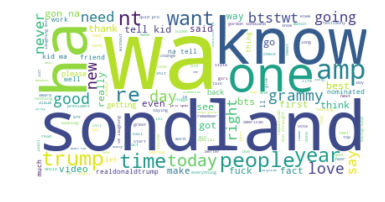

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


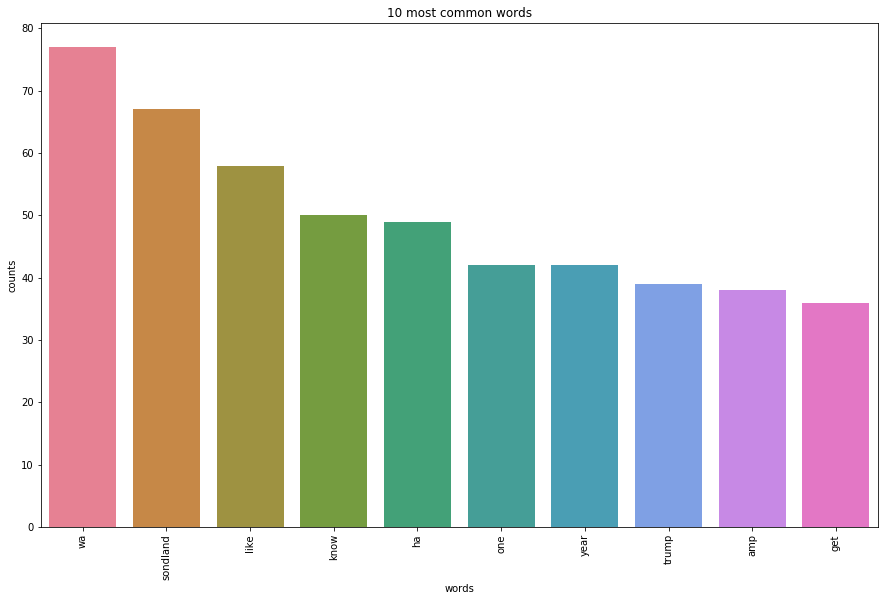

In [24]:
oldaTopics = trainOLDA()

In [25]:
oldaTopics['set'] = oldaTopics['topic'].map(lambda x: set(x.split()))

magnitude = {}
event_start = {}
event_end = {}

# We will go trough each tweet and try to match it to a topic
for _, row in df.iterrows():
    try:
        rowSet = set(row['text'].split())
    except:
        continue

    for _, topicRow in oldaTopics.iterrows():
        topicSet = topicRow['set']
        original_topic = topicRow['topic']
        
        if len(topicSet.intersection(rowSet)) > topicComparisonThreshold:
            if original_topic not in magnitude:
                magnitude[original_topic] = 0

            magnitude[original_topic] += 1
            given_date = row['date']
            
            if original_topic not in event_start:
                event_start[original_topic] = given_date
                
            if given_date < event_start[original_topic]:
                event_start[original_topic] = given_date
                
            if original_topic not in event_end:
                event_end[original_topic] = given_date
                
            if given_date > event_end[original_topic]:
                event_end[original_topic] = given_date


oldaData = []
for _, row in oldaTopics.iterrows():
    topic = row['topic']
    oldaData.append([topic, magnitude.get(topic, 0), event_start.get(topic, 'NULL'),event_end.get(topic, 'NULL')])
    
oldaDataFrame = pd.DataFrame(oldaData, columns=['Topic', 'Magnitude', 'StartDate', 'EndDate'])

print('With the matching threshold of ' + str(topicComparisonThreshold) + ' words we have: ')
oldaDataFrame

With the matching threshold of 3 words we have: 


,Topic,Magnitude,StartDate,EndDate
0,love amp much like year wow hyundai,0,NULL,NULL
1,re realdonaldtrump sondland like know day today,0,NULL,NULL
2,re know never friend least time hate,0,NULL,NULL
3,wa year ago good never new bts,0,NULL,NULL
4,fuck like ha grammys new mad stressing,0,NULL,NULL
5,pro quid quo wa sondland fact nothing,9,2019-11-20 15:24:41,2019-11-20 15:24:59
6,kid na gon tell wa sondland please,15,2019-11-20 15:24:41,2019-11-20 15:24:58
7,trump get god go tweet like sometimes,0,NULL,NULL
8,year wa said know nt grammys time,0,NULL,NULL
9,like know bts gt right nomination got,0,NULL,NULL
